In [ ]:
# imports
import numpy as np

In [ ]:
# Box Field CLASS
class BoxField:
    def __init__(self, size=5, item_start=(4, 4), start_position=(0, 0), item_drop_off=(4, 0)):
        self.size = size
        self.item_pickup = item_start
        self.item_start = item_start
        self.item_drop_off = item_drop_off
        self.start_position = start_position
        self.position = start_position
        self.item_in_car = False
        self.number_of_actions = 6
        self.actions = ['right', 'up', 'left', 'down', 'pick', 'drop']
        
    def reset(self):
        self.item_pickup = self.item_start
        self.position = self.start_position
        self.item_in_car = False

    
    def __str__(self):
        field_array = np.zeros((self.size, self.size))
        field_array = field_array.astype(str)
        if not self.item_in_car:
            field_array[self.position[0], self.position[1]] = 'x.x'
            field_array[self.item_pickup[0], self.item_pickup[1]] = '!.!'
        else:
            field_array[self.position[0], self.position[1]] = 'x.!'
        if self.item_drop_off != (self.position[0], self.position[1]):
            field_array[self.item_drop_off[0], self.item_drop_off[1]] = 'G.G'
        else:
            field_array[self.item_drop_off[0], self.item_drop_off[1]] = 'x.G'
        
        print(field_array)
        return f'Current Position: {self.position}\nItem in: {self.item_in_car}'

    
    def get_number_of_states(self):
        return self.size*self.size*self.size*self.size*2
    
    def get_state(self):
        state = self.position[0]*self.size*self.size*self.size*2
        state += self.position[1]*self.size*self.size*2
        state += self.item_pickup[0]*self.size*2
        state += self.item_pickup[1]*2
        if self.item_in_car:
            state += 1
        return state
        
    def make_action(self, action):
        (x, y) = self.position
        if action == 0:  # Go East
            if y == self.size - 1:
                return -10, False
            else:
                self.position = (x, y + 1)
                return -1, False
        elif action == 1:  # Go West
            if y == 0:
                return -10, False
            else:
                self.position = (x, y - 1)
                return -1, False
        elif action == 2:  # Go North
            if x == 0:
                return -10, False
            else:
                self.position = (x - 1, y)
                return -1, False
        elif action == 3:  # Go South
            if x == self.size - 1:
                return -10, False
            else:
                self.position = (x + 1, y)
                return -1, False
        elif action == 4:  # Pickup item
            if self.item_in_car:
                return -10, False
            elif self.item_pickup != (x, y):
                return -10, False
            else:
                self.item_in_car = True
                return 20, False
        elif action == 5:  # Drop off item
            if not self.item_in_car:
                return -10, False
            elif self.item_drop_off != (x, y):
                self.item_pickup = (x, y)
                self.item_in_car = False
                return -10, False
            else:
                self.item_pickup = (x, y)
                self.item_in_car = False
                return 50, True
        
# EXAMPLE Box Field
# In this example, the goal is to go to the box location, pick the box and drop it in the final location
field = BoxField()
print(field)

In [ ]:
# Walls Field CLASS
class WallsField:
    def __init__(self, size=5, start_index=0, goal_index=24, walls_indexes=[5, 6, 7, 8, 16,17,18,19]):
        self.reward_walls = -2
        self.reward_fall = -2
        self.reward_goal = 10
        self.start_index, self.goal_index, self.walls_indexes = start_index, goal_index, np.array(walls_indexes)
        self.size = size
        self.walls_position = np.argwhere(np.isin(np.arange(size*size).reshape(size, size), self.walls_indexes))
        self.walls_set = set(map(tuple, self.walls_position))
        self.start_position = np.unravel_index(start_index, (size, size))
        self.goal_position = np.unravel_index(goal_index, (size, size))
        self.position = np.unravel_index(start_index, (size, size))
        self.number_of_actions = 4
        self.actions = ['right', 'up', 'left', 'down']
        
    def reset(self):
        self.position = self.start_position

    
    def __str__(self):
        field_array = np.zeros((self.size, self.size))
        field_array = field_array.astype(str)
        field_array[self.position[0], self.position[1]] = 'x.x'
        field_array[self.walls_position[:,0], self.walls_position[:,1]] = 'WMW'
        field_array[self.goal_position[0], self.goal_position[1]] = 'G.G'
        field_array[self.position[0], self.position[1]] = 'x.x'

        print(field_array)
        return f'Current Position: {self.position}'

    
    def get_number_of_states(self):
        return self.size*self.size
    
    def get_state(self):
        state = self.position[0]*self.size
        state += self.position[1]
        return state
        
    def make_action(self, action):
        (x, y) = self.position
        if action == 0:  # Go East
            if y == self.size - 1:
                return self.reward_fall, False
            elif (x, y + 1) in self.walls_set:
                return self.reward_walls, False
            elif (x, y + 1) == self.goal_position:
                self.position = (x, y + 1)
                return self.reward_goal, True
            else:
                self.position = (x, y + 1)
                return -1, False
        elif action == 1:  # Go North
            if x == 0:
                return self.reward_fall, False
            elif (x - 1, y) in self.walls_set:
                return self.reward_walls, False
            elif (x - 1, y) == self.goal_position:
                self.position = (x - 1, y)
                return self.reward_goal, True
            else:
                self.position = (x - 1, y)
                return -1, False
        elif action == 2:  # Go West
            if y == 0:
                return self.reward_fall, False
            elif (x, y - 1) in self.walls_set:
                return self.reward_walls, False
            elif (x, y - 1) == self.goal_position:
                self.position = (x, y - 1)
                return self.reward_goal, True
            else:
                self.position = (x, y - 1)
                return -1, False
        elif action == 3:  # Go South
            if x == self.size - 1:
                return self.reward_fall, False
            elif (x + 1, y) in self.walls_set:
                return self.reward_walls, False
            elif (x + 1, y) == self.goal_position:
                self.position = (x + 1, y)
                return self.reward_goal, True
            else:
                self.position = (x + 1, y)
                return -1, False

# EXAMPLE Walls Field
# In this example, the goal is to get to the final location of the maze without hiting the walls
field = WallsField()
print(field)

In [ ]:
def naive_solution(field):
    field.reset()
    done = False
    steps = 0
    
    while not done:
        action = np.random.randint(0, field.number_of_actions)
        _, done = field.make_action(action)
        steps = steps + 1
    return steps

In [ ]:
def q_learning_episode(field, q_table):
    field.reset()
    epsilon = 0.1
    alpha = 0.1
    gamma = 0.9
    

    done = False
    steps = 0
    while not done:
        state = field.get_state()

        # POLICY
        if np.random.random() < epsilon:
            action = np.random.randint(0, field.number_of_actions)
        else:
            action = np.argmax(q_table[state])
            
        reward, done = field.make_action(action)
        new_state = field.get_state()
        new_state_max = np.max(q_table[new_state])
        
        #q_table[state, action] = (1 - alpha)*q_table[state, action] + alpha*(reward + gamma*new_state_max - q_table[state, action])
        q_table[state, action] += alpha*(reward + gamma*new_state_max - q_table[state, action])
        
        steps = steps + 1
        # in case the episode is taking too many steps to finish
        if steps >= 5000:
            break        
    return [steps, q_table]

In [ ]:
# PLOT FUNCTION
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output
from PIL import Image

def update_plot(q_table, obst_i, start_i, goal_i, image_i):
    def normalize_row(row):
        min_val = 0.15
        max_val = 0.9
        return np.interp(row, (row.min(), row.max()), (min_val, max_val))
    opacity_matrix = np.apply_along_axis(normalize_row, axis=1, arr=q_table)

    clear_output(wait=True)
    
    n_rows = opacity_matrix.shape[0]
    n_subplots = int(np.sqrt(n_rows))

    fig, axs = plt.subplots(n_subplots, n_subplots, sharex=True, sharey=True, figsize=(8, 8))

    x_start, y_start = 0, 0
    arrowhead_width = 0.3
    arrowhead_length = 0.15
    arrow_width = 0.05
    color = 'black'
    right_col = 0
    up_col = 1
    left_col = 2
    down_col = 3
    for i, ax in enumerate(axs.flatten()):
        opacity1, opacity2, opacity3, opacity4 = opacity_matrix[i][[right_col, up_col, left_col, down_col]]
        opacities = [opacity1, opacity2, opacity3, opacity4]
        if i == start_i:
            color = '#1C288C'
        else:
            color = 'black'

        if i in obst_i:
            # Load the image and resize it to fit the subplot
            img = Image.open('images/wall.png')
            img = img.resize((int(ax.get_window_extent().width), int(ax.get_window_extent().height)))
            # Plot the image in the center of the subplot
            ax.imshow(img, extent=(-0.4, 0.4, -0.3, 0.2))
        elif i == goal_i:
            # Load the image and resize it to fit the subplot
            img = Image.open('images/finish.png')
            img = img.resize((int(ax.get_window_extent().width), int(ax.get_window_extent().height)))
            # Plot the image in the center of the subplot
            ax.imshow(img, extent=(-0.6, 0.6, -0.5, 0.6))
        else:
            for j in range(4):
                x_end = np.cos(j * np.pi/2) * 0.3
                y_end = np.sin(j * np.pi/2) * 0.3
                ax.arrow(x_start, y_start, x_end, y_end, head_width=arrowhead_width, width=arrow_width,
                        head_length=arrowhead_length, fc=color, ec=color, alpha=opacities[j])

        ax.set_xlim([-0.6, 0.6])
        ax.set_ylim([-0.6, 0.6])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(str(i), x=.2, y=.6)

        if i == image_i:
            # Load the image and resize it to fit the subplot
            img = Image.open('images/robot.png')
            img = img.resize((int(ax.get_window_extent().width), int(ax.get_window_extent().height)))
            # Plot the image in the center of the subplot
            ax.imshow(img, extent=(-0.3, 0.3, -0.2, 0.2))

    fig.suptitle('Q-Table Values with Arrows')
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    plt.show()


In [ ]:
# Naive Solution (random walk)

field = WallsField()
n_epsiodes = 100
print('Naive Solution (random walk)')
runs = [naive_solution(field) for _ in range(n_epsiodes)]
print('Average steps:', sum(runs)/len(runs))


In [ ]:
# CREATE MAZE
# Define the grid world size n x n
n = 5
# Start state position
start_i = 17
# Goal state position
goal_i = 20
# Walls positions
walls_i = [3, 6, 11, 12, 13, 16, 18, 21]

# Instantiate Environment
field = WallsField(n, start_i, goal_i, walls_i)
print(field)

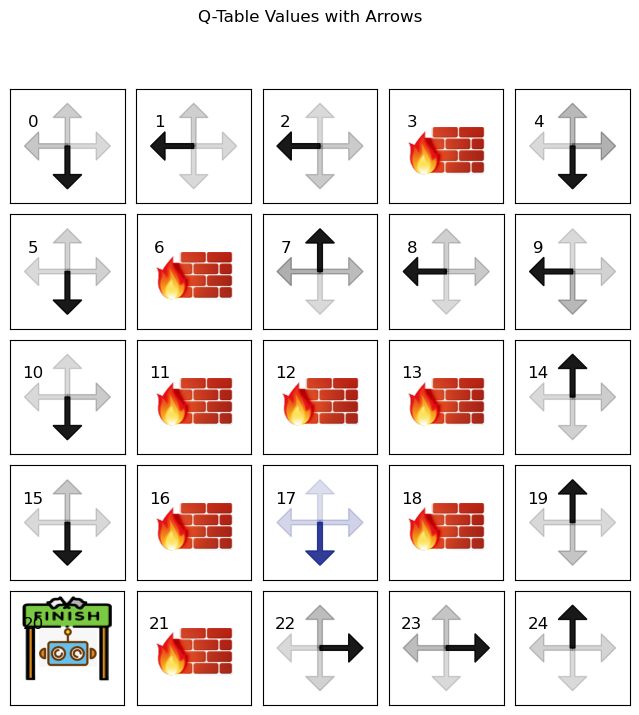

DONE!


,right,up,left,down
0,0.196040,0.453324,0.602785,4.580000
1,-0.910032,-0.720183,3.122000,-0.916839
2,-1.445051,-1.699643,1.809798,-1.428616
3,0.000000,0.000000,0.000000,0.000000
4,-4.370341,-4.384238,-4.433894,-4.130028
5,1.008456,0.980448,0.783031,6.200000
6,0.000000,0.000000,0.000000,0.000000
7,-2.581430,0.628812,-2.325793,-3.155174
8,-3.406861,-3.493784,-0.434089,-3.658510
9,-4.277347,-4.383170,-1.390748,-3.864289


In [11]:
# Q learning Algortithm Visualization
import pandas as pd

# TRAIN Q-LEARNING
def train_q_learning(field, show = True):
    
    # Initialize Q-Table
    q_table = np.zeros((field.get_number_of_states(), field.number_of_actions))
    print('Q Table - SHAPE:', q_table.shape)

    episodes = 250
    update_every = 5
    # Train/Update Q table
    for e in range(episodes):
        steps, q_table = q_learning_episode(field, q_table)
        print('EPISODE:', e, '\tSTEPS:', steps)
        if e % update_every == 0 and show:
            update_plot(q_table, walls_i, start_i, goal_i, -1)
            print(pd.DataFrame(q_table, columns=field.actions))

    if show: update_plot(q_table, walls_i, start_i, goal_i, -1)
    
    return q_table

# EVALUATE Q-LEARNING

def evaluate_q_learning(field, q_table):
    field.reset()
    walls_i, start_i, goal_i = field.walls_indexes, field.start_index, field.goal_index 
    update_plot(q_table, walls_i, start_i, goal_i, field.get_state())
    done = False
    steps = 0
    while not done:
        state = field.get_state()

        action = np.argmax(q_table[state])
        
        reward, done = field.make_action(action)
        steps = steps + 1
        
        clear_output(wait=True)
        update_plot(q_table, walls_i, start_i, goal_i, field.get_state())
    return steps

q_table = train_q_learning(field, show = True)
evaluate_q_learning(field, q_table)
print('DONE!')
pd.DataFrame(q_table, columns=field.actions)
